# 24FS\_I4DS27: Adversarial Attacks - Wie kann KI überlistet werden? <br> 08-eval-uap

In diesem Notebook wird die Pipeline entwickelt und getestet.

In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (16, 8)

In [15]:
from src.utils.uap_helper import *
from src.utils.transform_perturbation import AddImagePerturbation

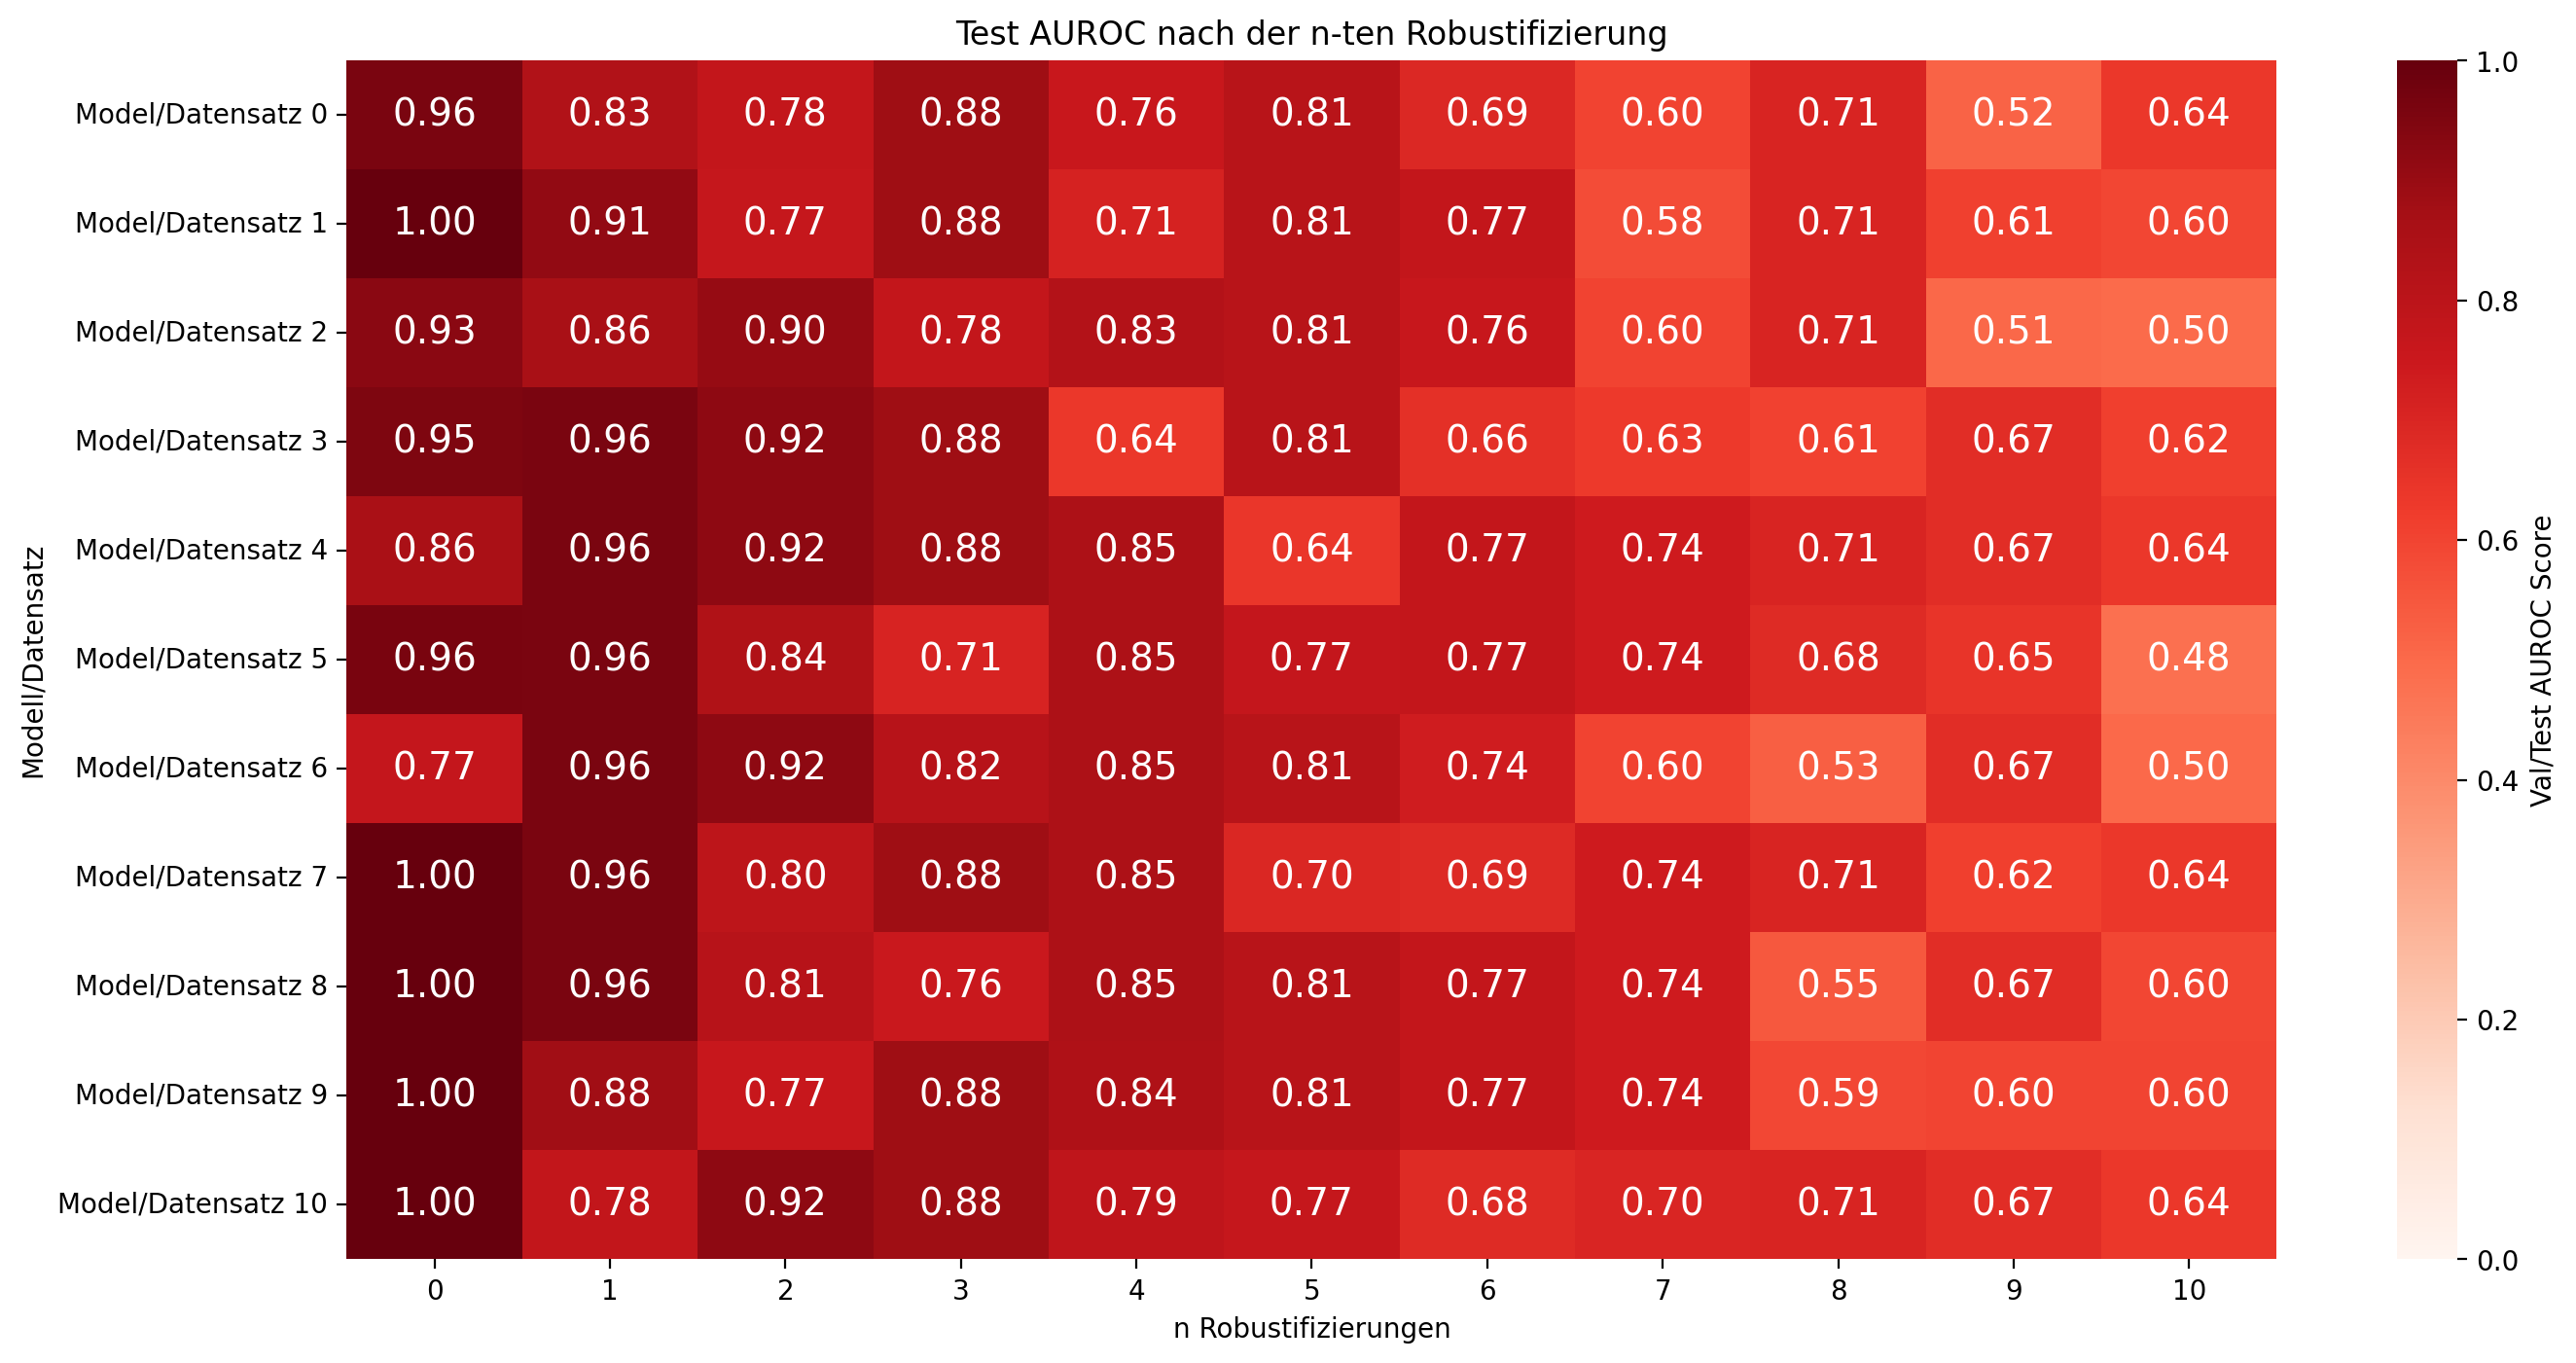

In [43]:
test_matrix = torch.linspace(1, 0.8, 11).repeat(11, 1)
test_matrix *= ((torch.rand_like(test_matrix) + 1.5) / 2).clip(0.5, 1) * test_matrix
test_matrix = test_matrix.clip(0, 1)

# plot heatmap  with numbers
sns.heatmap(
    test_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "Val/Test AUROC Score"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
)
plt.yticks(torch.linspace(0, 10, 11) + 0.5, [f"Model/Datensatz {i}" for i in range(11)], rotation=0)
plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Test AUROC nach der n-ten Robustifizierung")
plt.show()

Ziel: Schauen, ob das Modell nach den Robustifizierungen überhaupt noch gut funktioniert. (Performance Tradeoff?)

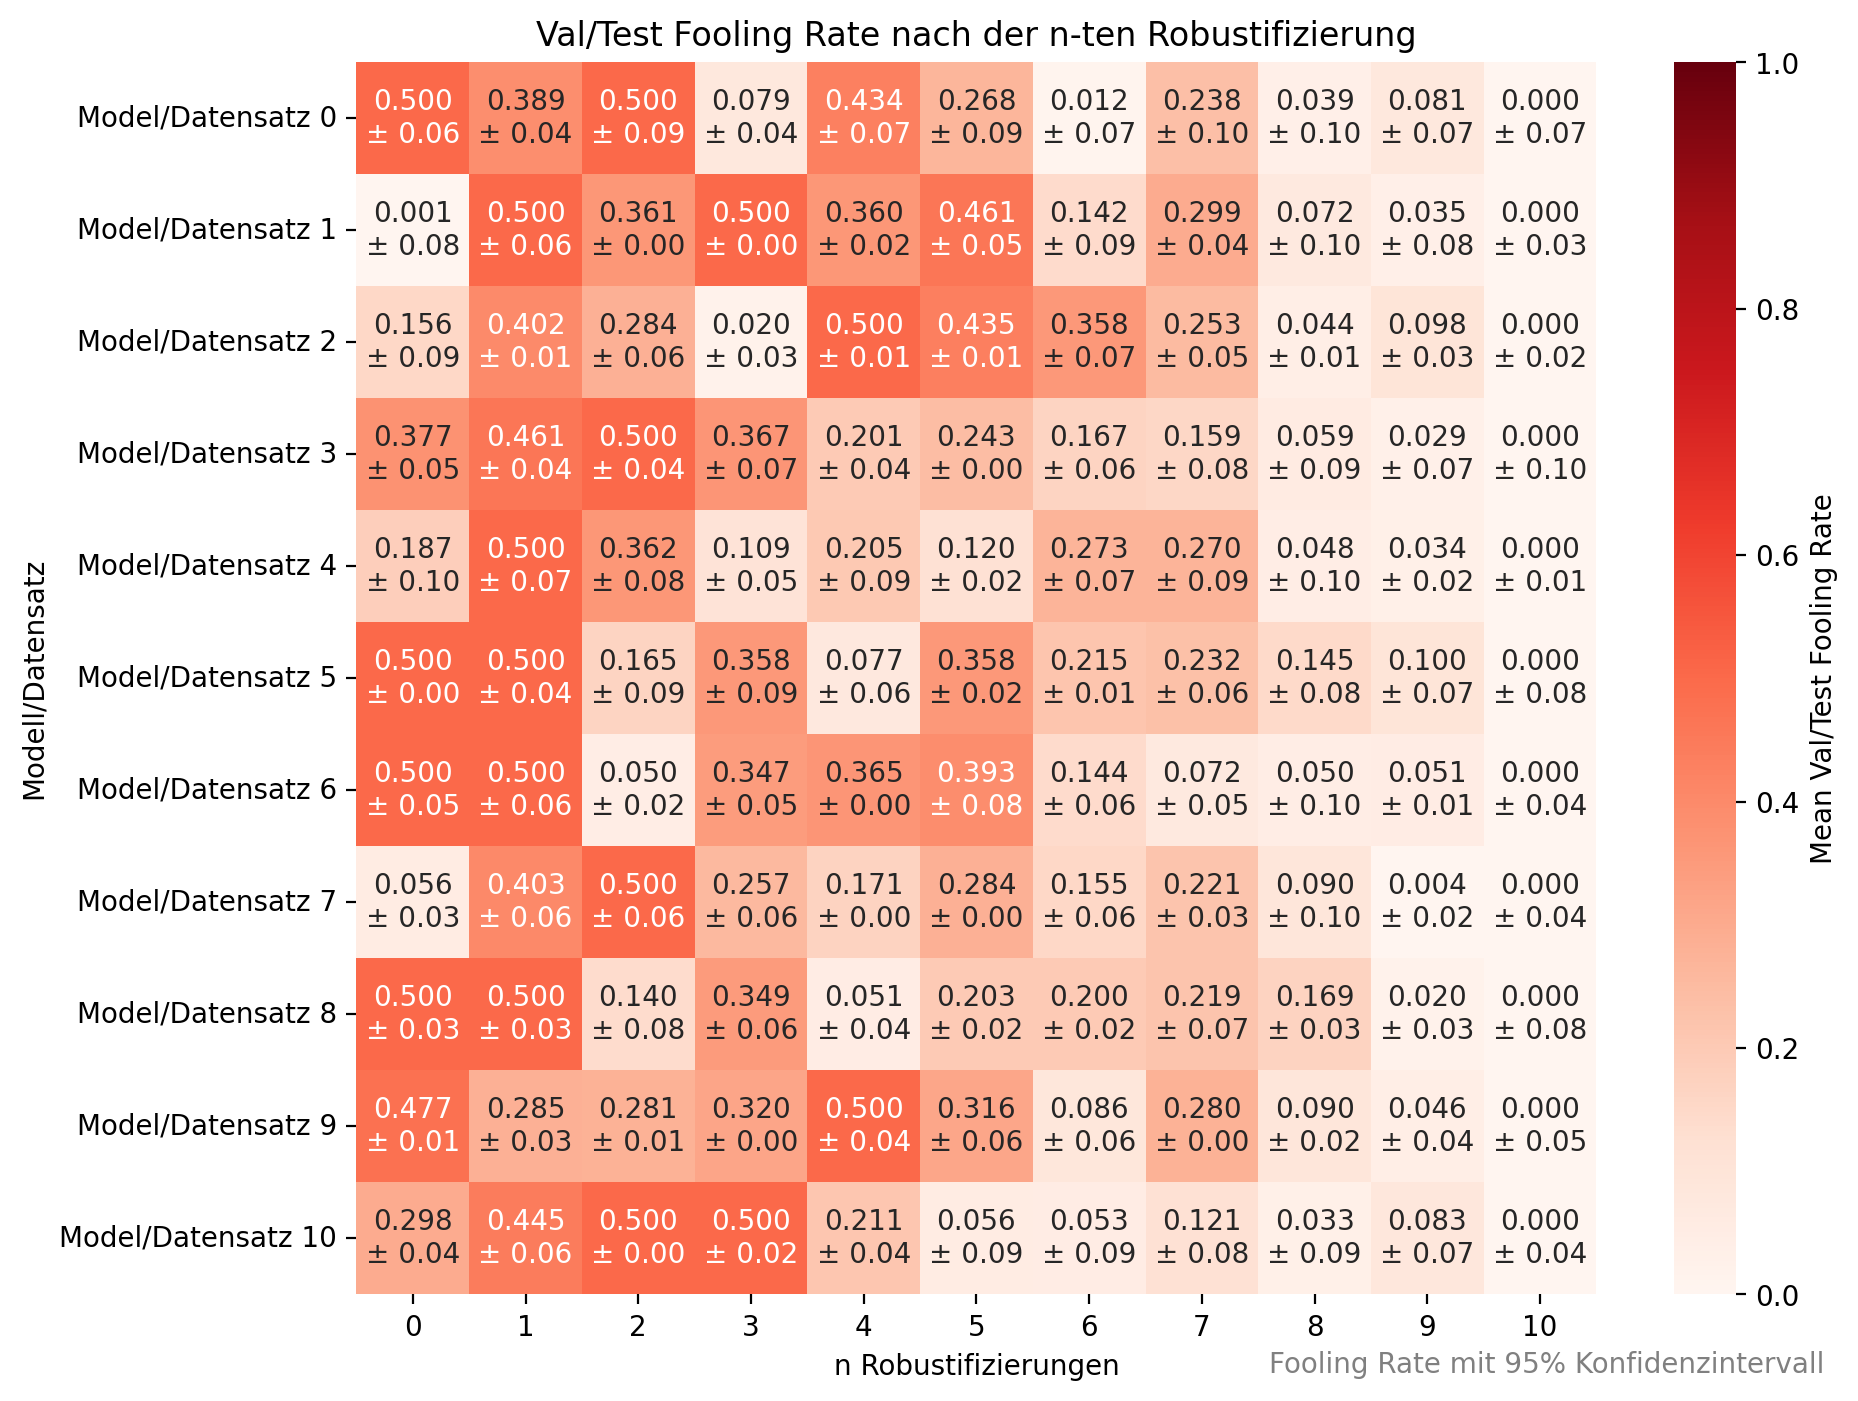

In [51]:
# Create the test matrix
test_matrix = torch.linspace(1, 0.0, 11).repeat(11, 1)
test_matrix *= torch.rand_like(test_matrix)
test_matrix = test_matrix.clip(0, 0.5)

# Generate random confidence intervals
conf_intervals = torch.rand_like(test_matrix) * 0.1

# Create annotations with confidence intervals
annot = np.empty(test_matrix.shape, dtype=object)
for i in range(test_matrix.shape[0]):
    for j in range(test_matrix.shape[1]):
        value = test_matrix[i, j].item()
        conf = conf_intervals[i, j].item()
        annot[i, j] = f"{value:.3f}\n± {conf:.2f}"

# Plot heatmap with numbers
plt.figure(figsize=(10, 8))
sns.heatmap(
    test_matrix,
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Mean Val/Test Fooling Rate"},
    vmin=0,
    vmax=1,
)
plt.yticks(torch.linspace(0, 10, 11) + 0.5, [f"Model/Datensatz {i}" for i in range(11)], rotation=0)
plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Val/Test Fooling Rate nach der n-ten Robustifizierung")
plt.suptitle("Fooling Rate mit 95% Konfidenzintervall", y=0.075, x=0.72, fontsize=10, c="gray")
plt.show()

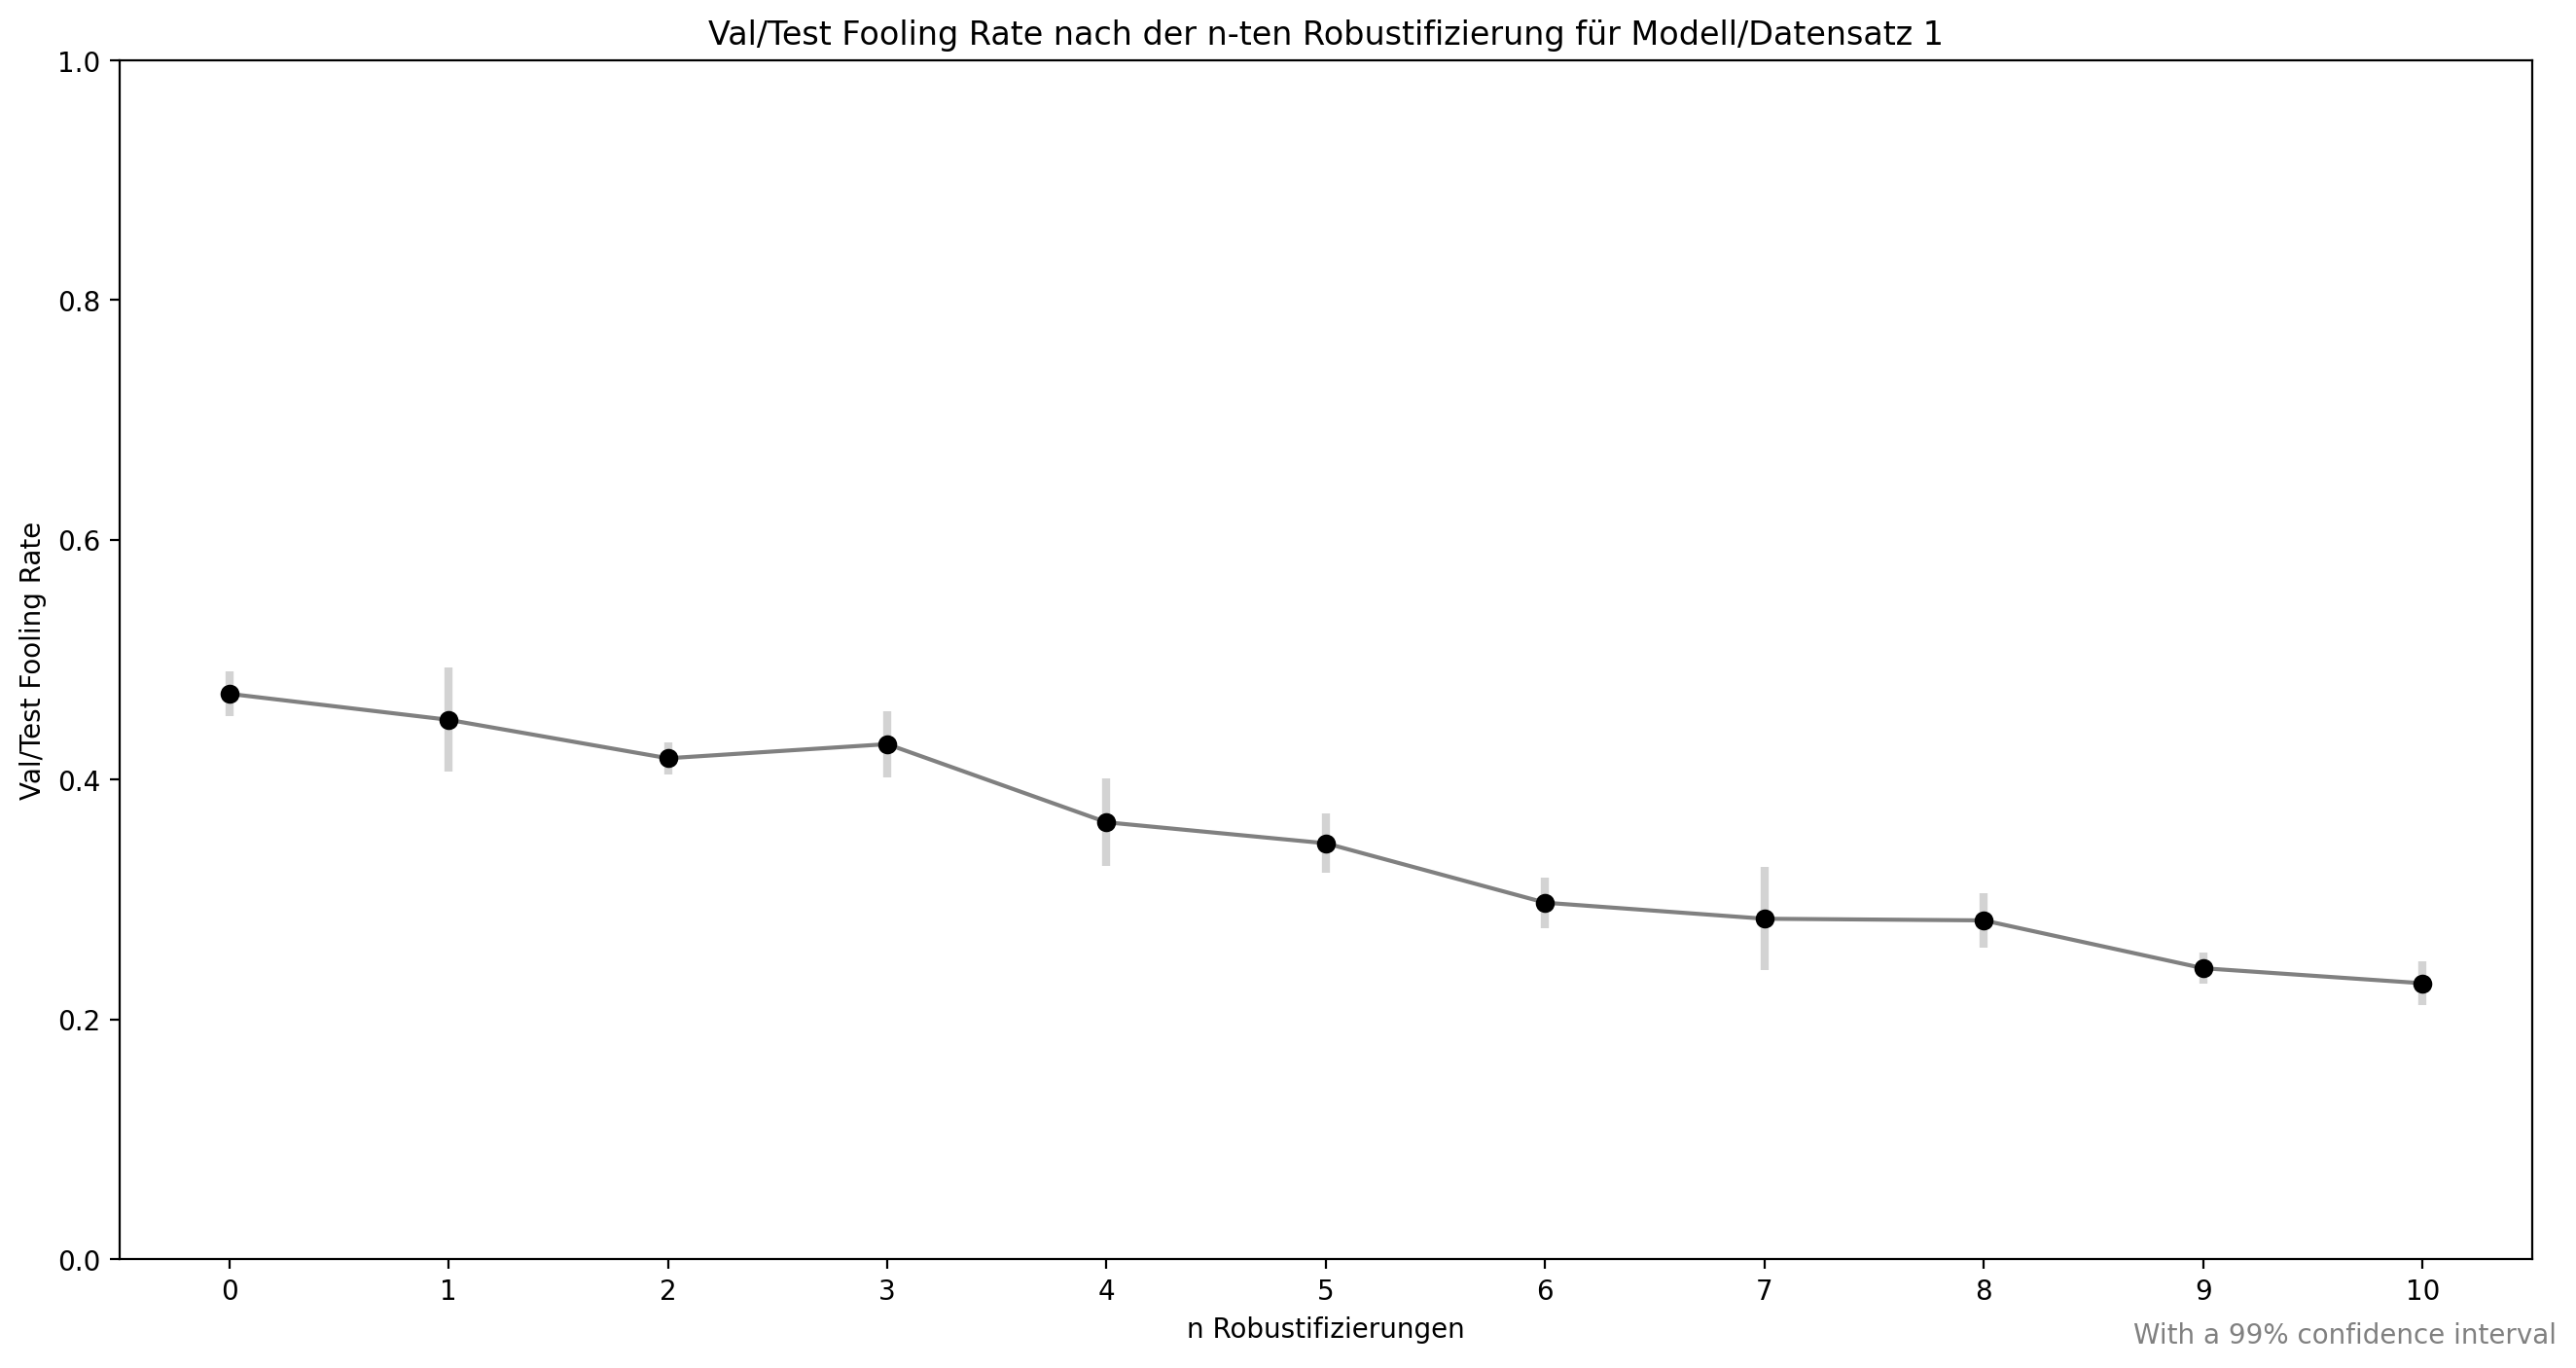

In [47]:
test_matrix = torch.linspace(0.5, 0.2, 11).repeat(5, 1)
test_matrix += ((torch.rand_like(test_matrix) - 0.5) * 2) * 0.05

means = test_matrix.mean(axis=0)
std_devs = test_matrix.std(axis=0)
n = test_matrix.shape[0]
conf_intervals = 2.576 * (std_devs / torch.sqrt(torch.tensor(n)))

robustification = torch.linspace(0, 10, 11)

plt.errorbar(
    robustification,
    means,
    yerr=conf_intervals,
    fmt="o",
    color="black",
    ecolor="lightgray",
    elinewidth=3,
    capsize=0,
)
plt.ylim(0,1)
plt.plot(robustification, means, "o-", color="grey")
plt.xlabel("n Robustifizierungen")
plt.ylabel("Val/Test Fooling Rate")
plt.title("Val/Test Fooling Rate nach der n-ten Robustifizierung für Modell/Datensatz 1")
plt.suptitle("With a 99% confidence interval", y=0.07, fontsize=10, x=0.84, c="gray")
plt.xticks(robustification)
plt.show()

Ziel: Schauen, ob die Test Samples mit UAP nach n-Robustifizierungen noch gefooled werden können.

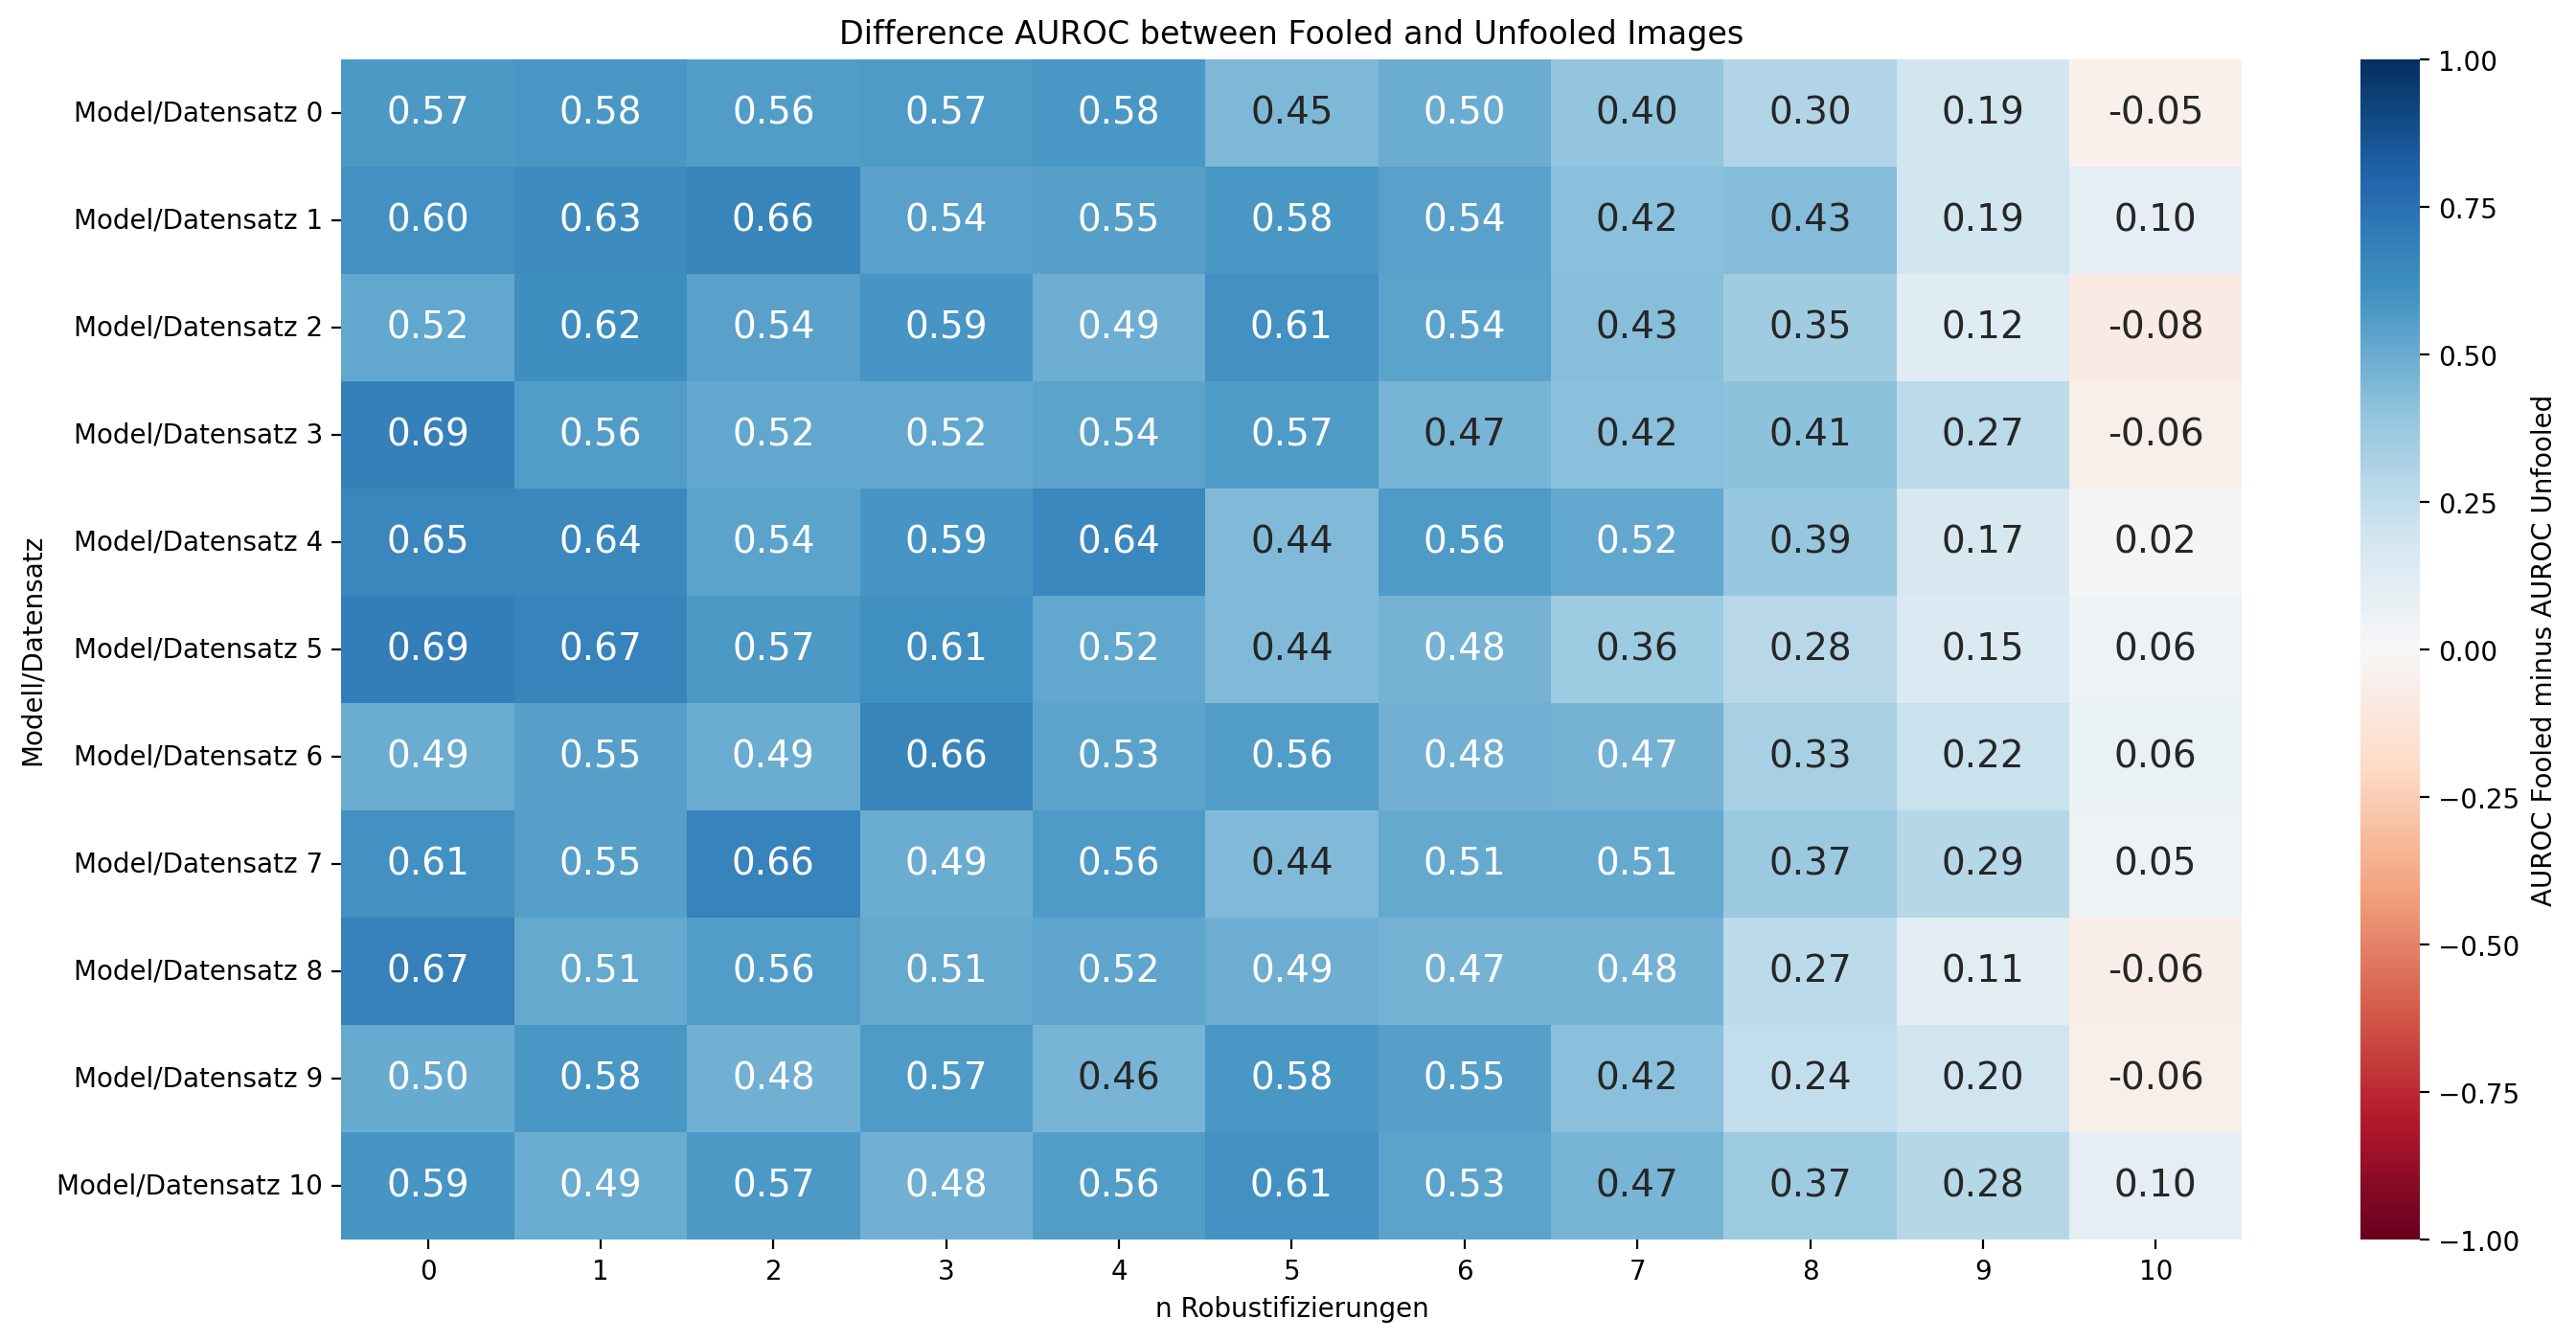

In [45]:
test_matrix = 0.5 - torch.logspace(
    torch.log10(torch.tensor(0.01)).item(), torch.log10(torch.tensor(0.6)).item(), steps=11
).repeat(11, 1)
test_matrix += (torch.rand_like(test_matrix)) * 0.2
test_matrix = test_matrix.clip(-1, 1)

# plot heatmap  with numbers
sns.heatmap(
    test_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0,
    cbar_kws={"label": "AUROC Fooled minus AUROC Unfooled"},
    annot_kws={"size": 14},
    vmin=-1,
    vmax=1,
)
plt.yticks(torch.linspace(0, 10, 11) + 0.5, [f"Model/Datensatz {i}" for i in range(11)], rotation=0)
plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Difference AUROC between Fooled and Unfooled Images")
plt.show()

Ziel: Differenz zwischen den Metriken mit und ohne Adv Attack

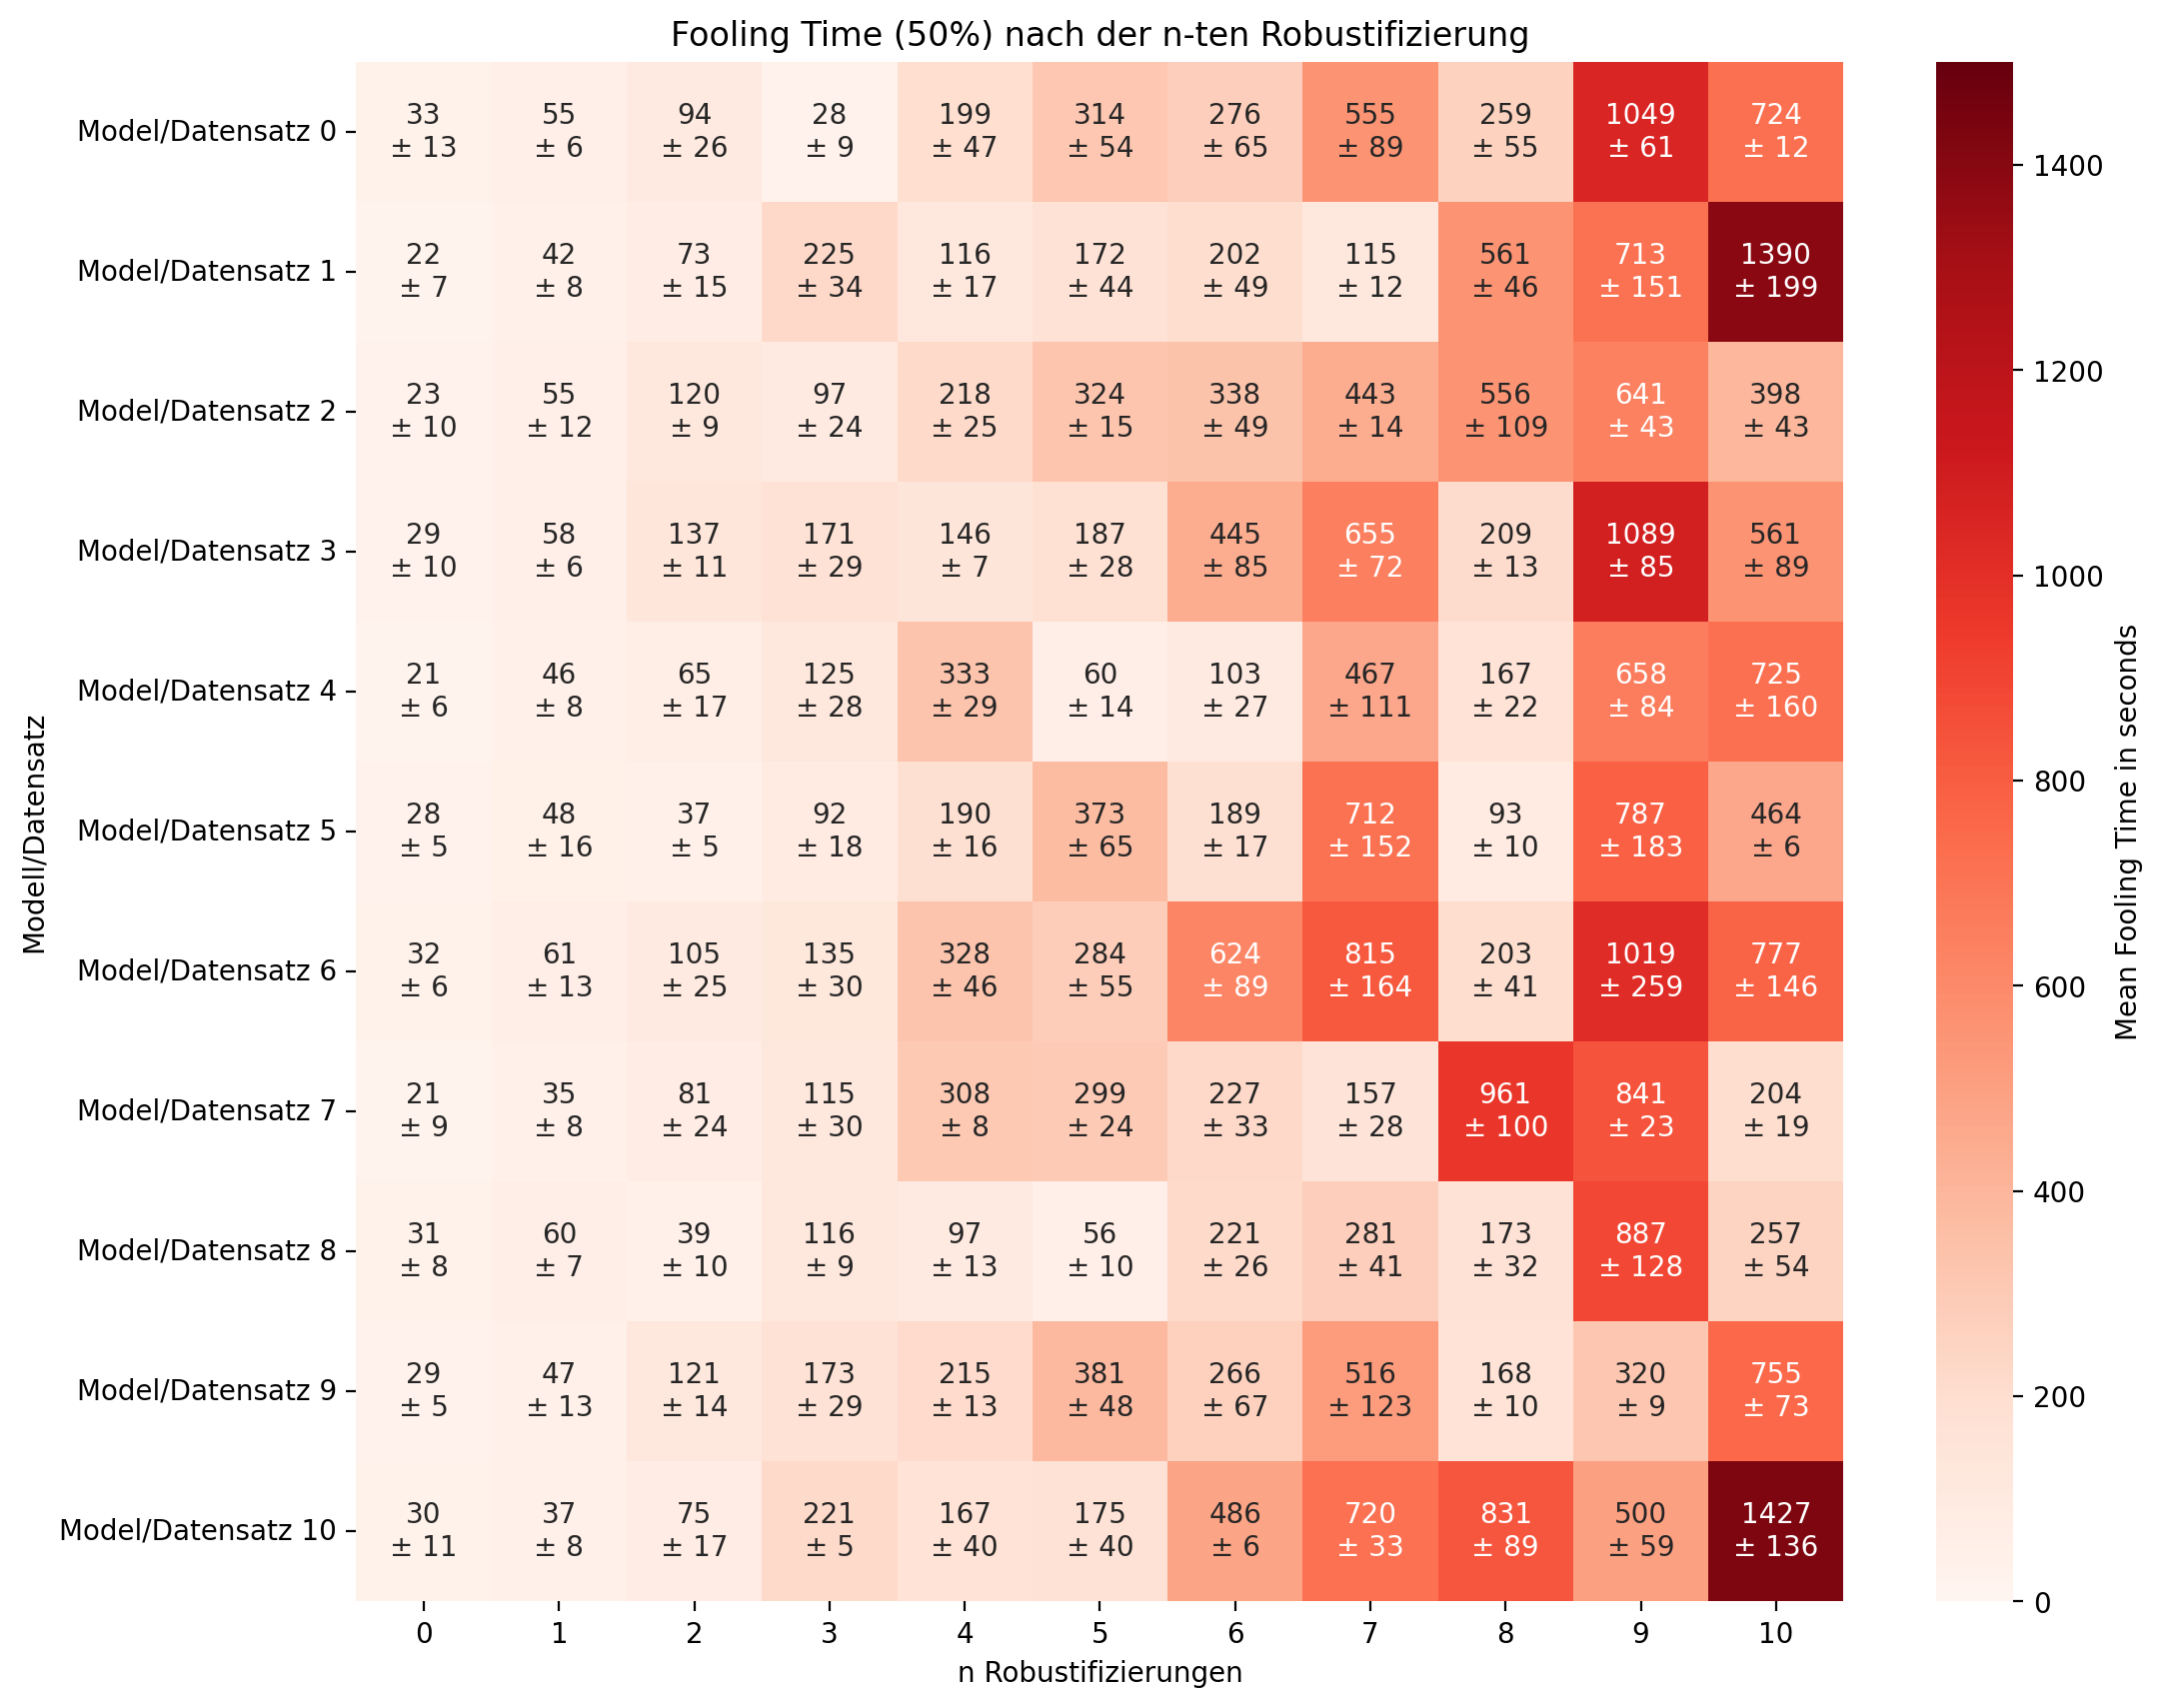

In [52]:
# Create the test matrix
max_time = 1500
test_matrix = torch.linspace(max_time / 10, max_time, 11).repeat(11, 1)
test_matrix *= torch.rand_like(test_matrix) * (test_matrix / max_time)
test_matrix += 20

# Generate random confidence intervals
conf_intervals = (torch.rand_like(test_matrix) * (test_matrix / 4)) + 5  # Adjust the scale as needed

# Create annotations with confidence intervals
annot = np.empty(test_matrix.shape, dtype=object)
for i in range(test_matrix.shape[0]):
    for j in range(test_matrix.shape[1]):
        value = test_matrix[i, j].item()
        conf = conf_intervals[i, j].item()
        annot[i, j] = f"{value:.0f}\n± {conf:.0f}"

# Define the colorbar range
vmin, vmax = 0, max_time

# Plot heatmap with numbers
plt.figure(figsize=(12, 10))
sns.heatmap(
    test_matrix,
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Mean Fooling Time in seconds"},
    annot_kws={"size": 10},
    vmin=vmin,
    vmax=vmax,
)
plt.yticks(torch.linspace(0, 10, 11) + 0.5, [f"Model/Datensatz {i}" for i in range(11)], rotation=0)
plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Fooling Time (50%) nach der n-ten Robustifizierung")
plt.show()

Ziel: Schauen, ob die Generation der Adv Attacks länger braucht nach der Robustifizierung